In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir kaggle
! cp '/content/drive/Shareddrives/Computer Vision Project/Colab_code/kaggle.json' '/content/'
! cp kaggle.json ~/.kaggle/
! chmod 600 kaggle.json
! kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research
! unzip '/content/covid-cxr-image-dataset-research.zip' -d'/content'
! rm '/content/covid-cxr-image-dataset-research.zip'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import itertools

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def import_image_to_array(directory_path, size):

    """
    Argument:
        directory_path - The path to the directory of the images to be imported.
        size - a tuple that describes the desired size to be imported

    Task(s) this function carry out:
        Import images from the specified dirctories and convert them to arrays/tensors

    Returns:
        image_arrays - arrays of the images imported

    """
    # Define empty lists to store the images array and their respective labels
    image_arrays = []

    directory = os.listdir(directory_path)

    for image_name in directory:

        # Load an image from the specified directory
        image = cv2.imread(directory_path + image_name)

        # Resize image to the specified size
        image = cv2.resize(image, size)

        # Update the image dataset and labels lists respectively
        image_arrays.append(image)

    return image_arrays

In [ ]:
NORMAL_DIR = "/content/COVID_IEEE/normal/"  # Normal CXR Image Dataset
VIRAL_DIR = "/content/COVID_IEEE/virus/"    # Viral Pneumonia CXR Image Dataset
COVID_DIR = "/content/COVID_IEEE/covid/"    # COVID-19 CXR Image Dataset

normal_dataset = import_image_to_array(NORMAL_DIR, (224,224))
viral_dataset = import_image_to_array(VIRAL_DIR, (224,224))
covid_dataset = import_image_to_array(COVID_DIR, (224,224))

In [ ]:
print("The Dataset which is made up of {} Image Arrays has: ".format(len(normal_dataset) + len(viral_dataset) + len(covid_dataset)))
print('{} Normal CXR Image Arrays'.format(len(normal_dataset)))
print('{} Viral Pneumonia CXR Image Arrays'.format(len(viral_dataset)))
print('{} COVID-19 CXR Image Arrays'.format(len(covid_dataset)))

The Dataset which is made up of 1823 Image Arrays has: 
668 Normal CXR Image Arrays
619 Viral Pneumonia CXR Image Arrays
536 COVID-19 CXR Image Arrays


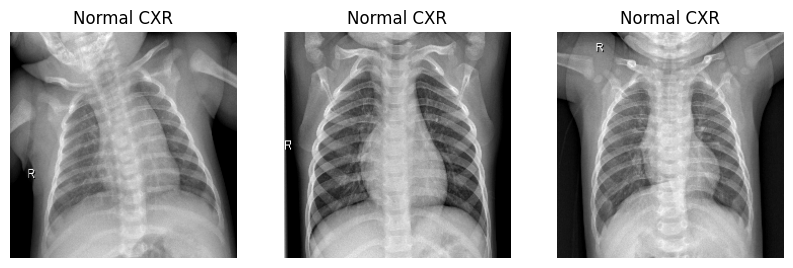

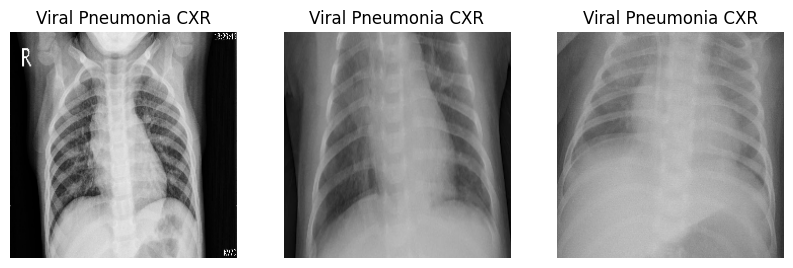

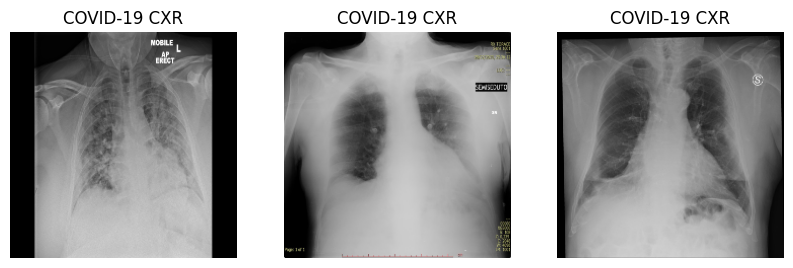

In [ ]:
class_names = {0: "Normal CXR", 1 : "Viral Pneumonia CXR", 2: "COVID-19 CXR"}

# Normal CXR Sampling
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(normal_dataset[images], cmap = "gray")
    plt.title(class_names[0])
    plt.axis("off")

# Viral Pneumonia CXR Sampling
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(viral_dataset[images], cmap = "gray")
    plt.title(class_names[1])
    plt.axis("off")

# COVID-19 CXR Sampling
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(covid_dataset[images], cmap = "gray")
    plt.title(class_names[2])
    plt.axis("off")

In [ ]:
def white_balance(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [ ]:
def clahe():
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    return clahe

In [ ]:
def image_enhancer(image_arrays):

    """
    Argument:
    image_arrays: a list containing arrays of images to be normalized

    returns:
    enhanced_images: a list of the enhanced images arrays
    """
    enchanced_images = []

    for image in image_arrays:

        # White Balance
        image_WB  = np.dstack([white_balance(channel, 0.05) for channel in cv2.split(image)] )
        gray_image = cv2.cvtColor(image_WB, cv2.COLOR_RGB2GRAY)

        # CLAHE
        clahe_function = clahe()
        image_clahe = clahe_function.apply(gray_image)
        image = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)


        enchanced_images.append(image)

    return enchanced_images

In [ ]:
normal_dataset_enhanced = image_enhancer(normal_dataset)
viral_dataset_enhanced = image_enhancer(viral_dataset)
covid_dataset_enhanced = image_enhancer(covid_dataset)

(-0.5, 223.5, 223.5, -0.5)

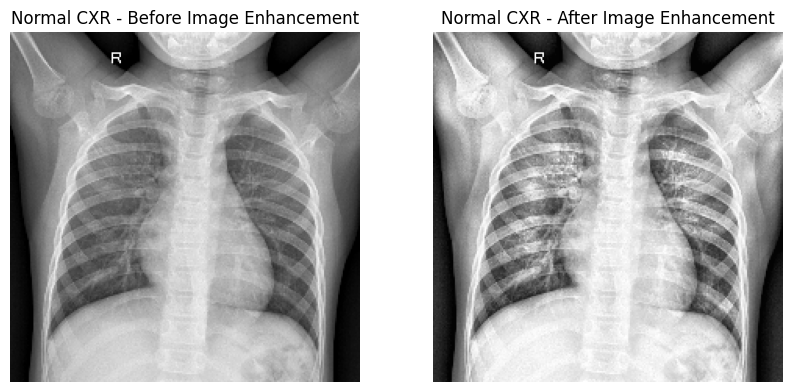

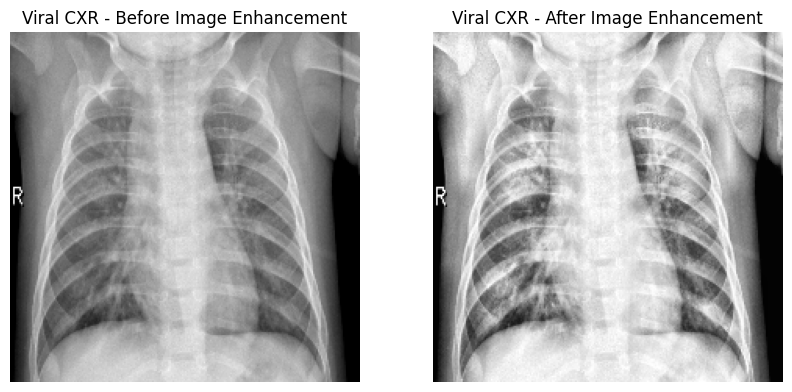

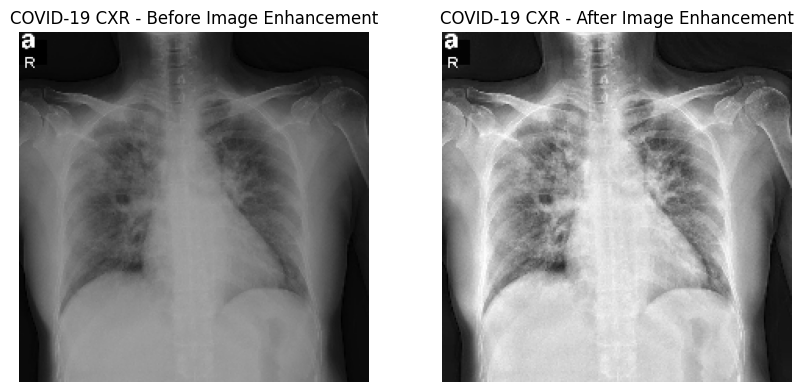

In [ ]:
# Normal CXR Sampling
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(normal_dataset[100], cmap = "gray")
plt.title("Normal CXR - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(normal_dataset_enhanced[100], cmap = "gray")
plt.title("Normal CXR - After Image Enhancement")
plt.axis("off")

# Viral Pneumonia CXR Sampling
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(viral_dataset[100], cmap = "gray")
plt.title("Viral CXR - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(viral_dataset_enhanced[100], cmap = "gray")
plt.title("Viral CXR - After Image Enhancement")
plt.axis("off")

# COVID-19 CXR Sampling
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(covid_dataset[100], cmap = "gray")
plt.title("COVID-19 CXR - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(covid_dataset_enhanced[100], cmap = "gray")
plt.title("COVID-19 CXR - After Image Enhancement")
plt.axis("off")

In [ ]:
def normalizer(image_arrays):

    """
    Argument:
        image_arrays: array of images to be normalized

    returns:
        normalized_images_array: array of the normalized images' arrays
    """
    # Create an empty list to store normalized arrays
    norm_image_arrays = []

    # Iterate over all the image arrays and normalize them before storing them into our predefined list
    for image_array in image_arrays:
        norm_image_array = image_array / 255.0
        norm_image_arrays.append(norm_image_array)

    return norm_image_arrays

In [ ]:
normal_dataset_normalized = normalizer(normal_dataset)
viral_dataset_normalized = normalizer(viral_dataset)
covid_dataset_normalized = normalizer(covid_dataset)

In [ ]:
def split_and_merge_function(image_arrays, split_factor = [0.7, 0.15, 0.15]):

    """
    Argument:
        image_arrays - A list or tuple of the images to be imported.
        data_labels - A list of the data labels
        split_factor - A list or tuple that determines how the dataset is splitted into training, validation and test dataset

    Task(s) carried out:
        Split the dataset into training, validation, and test sets
        Merge the sets of each categories

    Returns:
    datasets - a dictionary containing the training, validation and test datasets (arrays of the images imported
                and their respective labels)

    """
    # Define an empty dictionary to hold the training, validation and test datasets
    datasets = {}
    # Calculate the number of image categories in the list argument passed to this function
    number_of_categories = len(image_arrays)

    train_dataset, validation_dataset, test_dataset, train_labels, validation_labels, test_labels = [], [], [], [], [], []

    for image_array_id in range(number_of_categories):
        image_array = image_arrays[image_array_id]

        # Update the data and labels lists, respectively
        dataset = [[image_array[image_id], [image_array_id]] for image_id in range(len(image_array))]

        # Split the data and labels into the train, validation, and test datasets
        train_dataset.extend(np.array(dataset[ : int(np.around(len(dataset) * split_factor[0]))]))
        validation_dataset.extend(np.array(dataset[int(np.around(len(dataset) * split_factor[0])) : int(np.around(len(dataset) * (split_factor[0] + split_factor[1])))]))
        test_dataset.extend(np.array(dataset[int(np.around(len(dataset) * (split_factor[0] + split_factor[1]))) : ]))

        # Randomize the train, validation and test datasets
        random.seed(42) # Define a random state parameter to ensure the dataset generated is the same regardless of how many iterations we run
        random.shuffle(train_dataset), random.shuffle(validation_dataset), random.shuffle(test_dataset)

        # Split the data and label pairs and add them to the data and labels lists
        train_data = [dataset[0] for dataset in train_dataset]
        train_labels = [dataset[1] for dataset in train_dataset]
        validation_data = [dataset[0] for dataset in validation_dataset]
        validation_labels = [dataset[1] for dataset in validation_dataset]
        test_data = [dataset[0] for dataset in test_dataset]
        test_labels = [dataset[1] for dataset in test_dataset]


    # Store train, validation and test datasets into the datasets dictionary
    datasets['train_dataset'] = np.array(train_data)
    datasets['validation_dataset'] = np.array(validation_data)
    datasets['test_dataset'] = np.array(test_data)

    # Convert labels from label-encoding to one-hot encoding and store in the datasets dictionary
    datasets['train_labels'] = to_categorical(np.array(train_labels))
    datasets['validation_labels'] = to_categorical(np.array(validation_labels))
    datasets['test_labels'] = to_categorical(np.array(test_labels))

    return datasets

In [ ]:
image_arrays = [normal_dataset_normalized, viral_dataset_normalized, covid_dataset_normalized]
datasets = split_and_merge_function(image_arrays, split_factor = [0.7, 0.15, 0.15])

In [ ]:
train_dataset = datasets['train_dataset']
validation_dataset = datasets['validation_dataset']
test_dataset = datasets['test_dataset']
train_labels = datasets['train_labels']
validation_labels = datasets['validation_labels']
test_labels = datasets['test_labels']

In [ ]:
print("The Dataset which is made up of {} Image Arrays has been splitted into:".format(len(train_dataset) + len(validation_dataset) + len(test_dataset)))
print('{} Training Image Arrays'.format(len(train_dataset)))
print('{} Validation Image Arrays'.format(len(validation_dataset)))
print('{} Test Image Arrays'.format(len(test_dataset)))

The Dataset which is made up of 1823 Image Arrays has been splitted into:
1276 Training Image Arrays
274 Validation Image Arrays
273 Test Image Arrays


In [ ]:
def data_augmenter():
    """
    Create a simple function to augment training images
    Returns:
        tf.keras.Sequential

    """

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.3))

    return data_augmentation

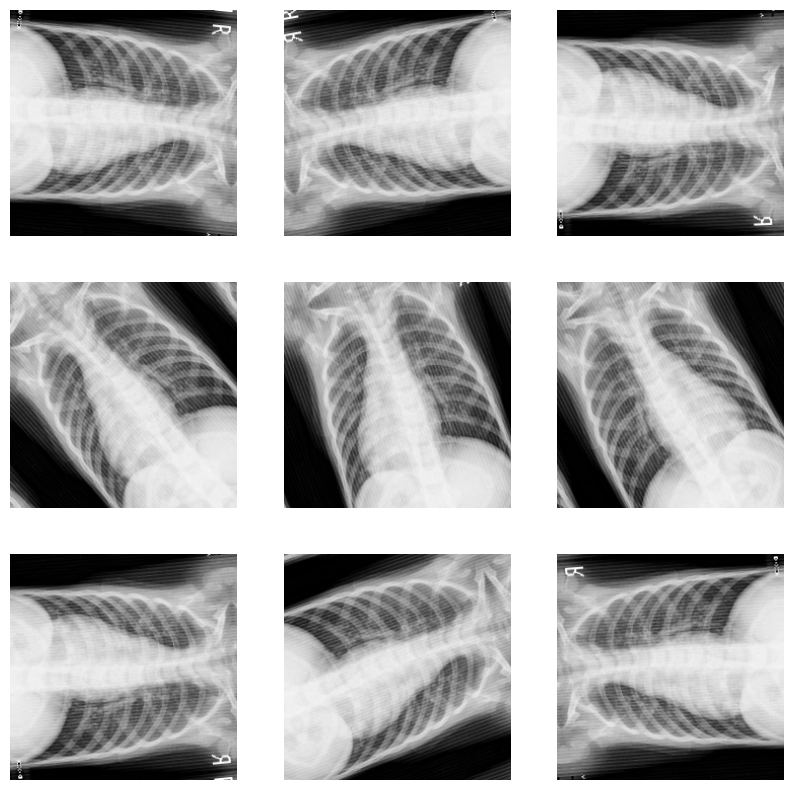

In [ ]:
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
first_image = train_dataset[6]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    exp = tf.expand_dims(first_image, 0)
    augmented_image = data_augmentation(exp)
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [ ]:
def make_mobilenet_model(image_size, num_classes, data_augmentation = data_augmenter()):

    input_shape = image_size + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters

    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)

    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)

    prediction_layer = Dense(units, activation=activation)

    outputs = prediction_layer(x)

    model = Model(inputs, outputs)

    return model

In [ ]:
# Define a model using the make_model function
image_size = (224,224)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 3)

# Preview the Model Summary
mobilenet_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                

In [ ]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 30
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)

In [ ]:
train_dataset.shape

(1276, 224, 224, 3)

In [ ]:
mobilenet_history_freeze = mobilenet_model.fit(train_dataset, train_labels,
                                               batch_size = batch_size,
                                               epochs = initial_epochs,
                                               validation_data = (validation_dataset, validation_labels),
                                               callbacks = [callback, reduce_lr],
                                               shuffle = True)

Epoch 1/30
20/20 [==============================] - 15s 311ms/step - loss: 1.1775 - accuracy: 0.4922 - val_loss: 0.7150 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 2s 112ms/step - loss: 0.7644 - accuracy: 0.6889 - val_loss: 0.5624 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 3s 138ms/step - loss: 0.6098 - accuracy: 0.7476 - val_loss: 0.4913 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 2s 114ms/step - loss: 0.5048 - accuracy: 0.7829 - val_loss: 0.4748 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 3s 147ms/step - loss: 0.4601 - accuracy: 0.8190 - val_loss: 0.4307 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 3s 126ms/step - loss: 0.4436 - accuracy: 0.8237 - val_loss: 0.4337 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 2s 109ms/step - l

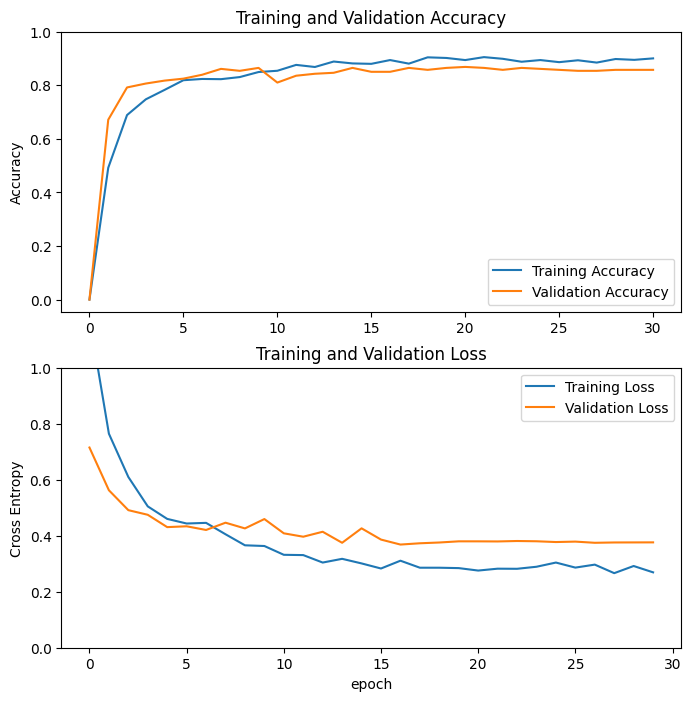

In [ ]:
acc = [0.] + mobilenet_history_freeze.history['accuracy']
val_acc = [0.] + mobilenet_history_freeze.history['val_accuracy']

loss = mobilenet_history_freeze.history['loss']
val_loss = mobilenet_history_freeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_mobilenet_model = mobilenet_model.layers[2] # MobileNetV2 Architecture
base_mobilenet_model.trainable = True

# The MobileNet Model has 155 layers (the prediction layer inclusive)
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_mobilenet_model.layers[:fine_tune_at]:
    layer.trainable = True


optimizer = Adam(learning_rate = 0.1 * base_learning_rate)
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
                        loss = loss,
                        metrics = metrics)

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

mobilenet_history_fine = mobilenet_model.fit(train_dataset, train_labels,
                                             epochs = total_epochs,
                                             batch_size = batch_size,
                                             initial_epoch = mobilenet_history_freeze.epoch[-1],
                                             callbacks = [callback, reduce_lr],
                                             validation_data = (validation_dataset, validation_labels),
                                             shuffle = True)

Epoch 30/60
20/20 [==============================] - 39s 558ms/step - loss: 1.3268 - accuracy: 0.5674 - val_loss: 0.6522 - val_accuracy: 0.7153 - lr: 1.0000e-04
Epoch 31/60
20/20 [==============================] - 7s 338ms/step - loss: 0.4048 - accuracy: 0.8433 - val_loss: 0.3778 - val_accuracy: 0.8686 - lr: 1.0000e-04
Epoch 32/60
20/20 [==============================] - 6s 317ms/step - loss: 0.2831 - accuracy: 0.9020 - val_loss: 0.4395 - val_accuracy: 0.8285 - lr: 1.0000e-04
Epoch 33/60
20/20 [==============================] - 7s 331ms/step - loss: 0.2808 - accuracy: 0.9028 - val_loss: 0.3027 - val_accuracy: 0.8869 - lr: 1.0000e-04
Epoch 34/60
20/20 [==============================] - 7s 334ms/step - loss: 0.2347 - accuracy: 0.9091 - val_loss: 0.3115 - val_accuracy: 0.8723 - lr: 1.0000e-04
Epoch 35/60
20/20 [==============================] - 6s 324ms/step - loss: 0.1693 - accuracy: 0.9459 - val_loss: 0.6460 - val_accuracy: 0.7591 - lr: 1.0000e-04
Epoch 36/60
20/20 [====================

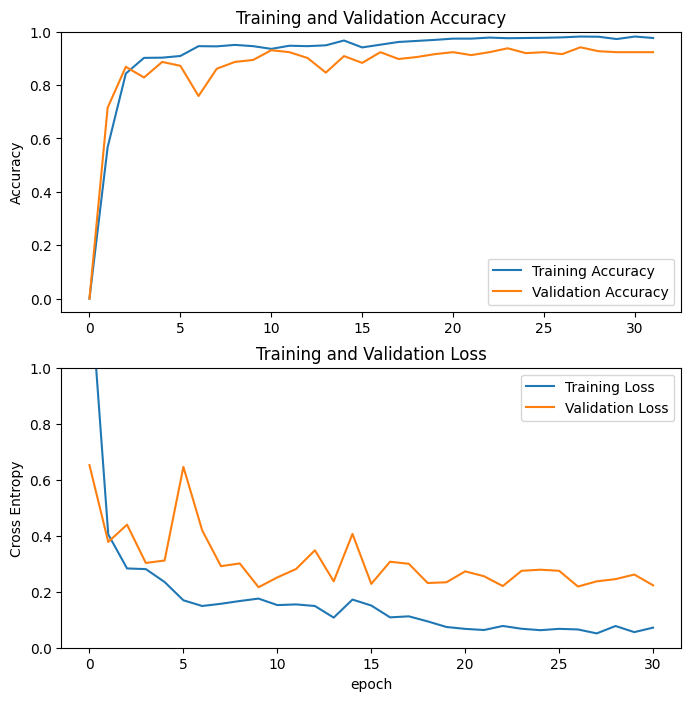

In [ ]:
acc = [0.] + mobilenet_history_fine.history['accuracy']
val_acc = [0.] + mobilenet_history_fine.history['val_accuracy']

loss = mobilenet_history_fine.history['loss']
val_loss = mobilenet_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
mobilenet_model.save('/content/drive/Shareddrives/Computer Vision Project/COVID-19/mobilenet-covid-19-cxr-classification-model.h5')

In [ ]:
# Load model
mobilenet_model = load_model('/content/drive/Shareddrives/Computer Vision Project/COVID-19/mobilenet-covid-19-cxr-classification-model.h5')

In [ ]:
training_predictions = mobilenet_model.predict(train_dataset, batch_size = 64)

# The predictions for the each image come as an array of number of classes in the model. e.g [0.05, 0.20, 0.75] for a model predicting three classes
# In this case, the model predict the probabilties that an x-ray image is normal, covid-19 or pnemonia, and store all of these values in an array
# Hence for us to know the predicted class, we have to identify the label with corresponding largest predicted probability
# The np.argmax returns the index of the largest probability. e.g it will return 2 for an array [0.1, 0.15, 0.75]
training_predictions_classes = np.argmax(training_predictions, axis=1)
training_labels_classes = np.argmax(train_labels, axis=1) # Position of the actual label

# Return a nicely formatted classification report

print(classification_report(training_labels_classes, training_predictions_classes, target_names=['normal','covid','virus']))

20/20 [==============================] - 2s 77ms/step
              precision    recall  f1-score   support

      normal       0.90      0.99      0.94       468
       covid       0.99      0.90      0.94       433
       virus       1.00      0.97      0.98       375

    accuracy                           0.95      1276
   macro avg       0.96      0.95      0.96      1276
weighted avg       0.96      0.95      0.95      1276



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          target_names = ['Normal','Covid-19','Viral Pneumonia'] , length = 1):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names = target_names

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,'%d (%.2f%%)'%(cm[i, j], cm[i, j] * 100/ length),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_predictions = mobilenet_model.predict(test_dataset, batch_size = 64)

# The predictions for the each image come as an array of number of classes in the model. e.g [0.05, 0.20, 0.75] for a model predicting three classes
# In this case, the model predict the probabilties that an x-ray image is normal, covid-19 or pnemonia, and store all of these values in an array
# Hence for us to know the predicted class, we have to identify the label with corresponding largest predicted probability
# The np.argmax returns the index of the largest probability. e.g it will return 2 for an array [0.1, 0.15, 0.75]
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_labels_classes = np.argmax(test_labels, axis=1) # Position of the actual label

# Return a nicely formatted classification report

print(classification_report(test_labels_classes, test_predictions_classes, target_names=['normal','covid','virus']))

5/5 [==============================] - 5s 248ms/step
              precision    recall  f1-score   support

      normal       0.89      0.99      0.94       100
       covid       0.98      0.89      0.93        93
       virus       1.00      0.96      0.98        80

    accuracy                           0.95       273
   macro avg       0.96      0.95      0.95       273
weighted avg       0.95      0.95      0.95       273



5/5 [==============================] - 0s 84ms/step


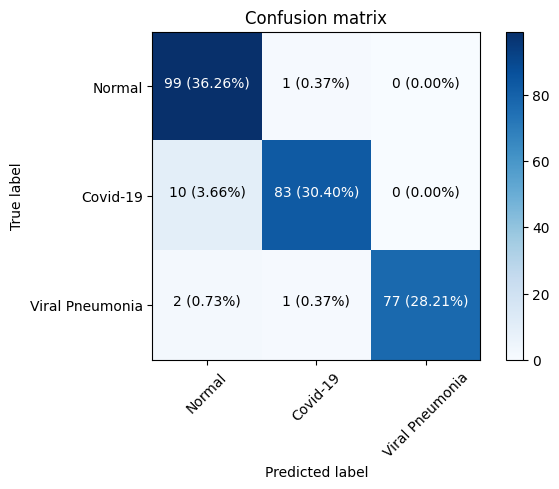

In [ ]:
# Predict the values from the validation dataset
test_predictions = mobilenet_model.predict(test_dataset, batch_size=64)
# Convert predictions classes to one hot vectors
test_predictions_classes = np.argmax(test_predictions, axis = 1)
test_labels_classes = np.argmax(test_labels, axis =1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
confusion_mtx_3 = confusion_matrix(test_labels_classes, test_predictions_classes)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_3, classes = range(3), length = len(test_dataset))